## Imbalance task – Individual

In [3]:
# If this cell does not work try running `pip install nbformat`

import io
import nbformat
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier


import re
import csv
from tqdm import tqdm

nb = nbformat.read("Lab1-Smote-2023.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 300


## Preprocess Data

In [4]:
data = "train_data.csv"
df1 = pd.read_csv(data)

#Encoding, Cleaning the data
df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

#Feature Engineering
df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

unique_issuer_cc = df1['issuercountrycode'].unique()
unique_shopper_cc = df1['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
lb = LabelBinarizer()
y = lb.fit_transform(df1['issuercountrycode'])

# Create a new DataFrame with the transformed 'issuercountrycode' column
df2 = pd.DataFrame(y, columns=['issuercountrycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'issuercountrycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('issuercountrycode', axis=1), df2], axis=1)

y = lb.fit_transform(df1['shoppercountrycode'])

# Create a new DataFrame with the transformed 'issuercountrycode' column
df2 = pd.DataFrame(y, columns=['shoppercountrycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'issuercountrycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('shoppercountrycode', axis=1), df2], axis=1)

def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)

lb2 = LabelBinarizer()
y = lb2.fit_transform(df1['txvariantcode'])

# Create a new DataFrame with the transformed 'txvariantcode' column
df2 = pd.DataFrame(y, columns=['txvariantcode_'+str(i) for i in range(y.shape[1])])

# Replace the 'txvariantcode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('txvariantcode', axis=1), df2], axis=1)

lb3 = LabelBinarizer()
y = lb3.fit_transform(df1['currencycode'])

# Create a new DataFrame with the transformed 'currencycode' column
df2 = pd.DataFrame(y, columns=['currencycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'currencycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('currencycode', axis=1), df2], axis=1)

lb4 = LabelBinarizer()
y = lb4.fit_transform(df1['shopperinteraction'])

# Create a new DataFrame with the transformed 'shopperinteraction' column
df2 = pd.DataFrame(y, columns=['shopperinteraction_'+str(i) for i in range(y.shape[1])])

# Replace the 'shopperinteraction' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('shopperinteraction', axis=1), df2], axis=1)

df1['accountcode'] = df1['accountcode'].apply(lambda x: re.sub('Account','',x))
df1['accountcode_cc'] = 0
df1.loc[(df1['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df1.loc[(df1['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df1.loc[(df1['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df1.loc[(df1['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

lb5 = LabelBinarizer()
y = lb5.fit_transform(df1['accountcode_cc'])

# Create a new DataFrame with the transformed 'accountcode_cc' column
df2 = pd.DataFrame(y, columns=['accountcode_cc_'+str(i) for i in range(y.shape[1])])

# Replace the 'accountcode_cc' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('accountcode_cc', axis=1), df2], axis=1)

df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

# drop id, mail_id, ip_id, card_id
df1 = df1.drop(['Id','mail_id','ip_id','card_id', 'amount', 'accountcode'], axis=1)

## Smote implementation

In [5]:

def smote_data(train, test):
    df = train.copy()
    df['label'] = test
    k = 5
    oversampling_ratio = 0.5
    # classify majority and minority class
    minority_class = df[df['label'] == 1]
    majority_class = df[df['label'] == 0]

    # calculate the difference between the two classes
    nsamples = int((len(majority_class) - len(minority_class)) * oversampling_ratio)

    # get samples from the minority class
    samples = minority_class.sample(n=nsamples, replace=True)

    # find k nearest neighbors of each sample in the minority class
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(minority_class)
    distances, indices = nbrs.kneighbors(samples)

    # create synthetic samples
    synthetic_samples = []
    for i in tqdm(range(len(samples))):
        # randomly select one of the k nearest neighbors x
        nn = indices[i]
        nn_index = np.random.choice(nn)
        # calculate the difference between the feature vector of the sample and x
        diff = minority_class.iloc[nn_index] - samples.iloc[i]
        r = np.random.rand()
        synthetic_sample = samples.iloc[i] + r * diff
        synthetic_samples.append(synthetic_sample)

    # convert the synthetic samples to a DataFrame
    synthetic_samples = pd.DataFrame(synthetic_samples, columns=df.columns)

    # add the synthetic samples to the minority class
    oversampled = pd.concat([minority_class, synthetic_samples])

    # combine with majority class
    smoted = pd.concat([majority_class, oversampled])

    return smoted


## Train the models

### Pre-smote

In [6]:
# Separate features and labels
X = df1.drop('label', axis=1)
y = df1['label']

# Define the number of folds
n_splits = 3

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize accuracy lists to store accuracy for each fold for each classifier
accuracy_list_decision_tree = []
accuracy_list_logistic= []
accuracy_list_random = []

y_predicts_all_dec_tree = []
y_truth_all_dec_tree = []
y_proba_all_dec_tree = []

y_predicts_all_logistic = []
y_truth_all_logistic = []
y_proba_all_logistic = []

y_predicts_all_random = []
y_truth_all_random = []
y_proba_all_random = []


round_counter = 0
# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    print('round ', round_counter, ' of ', n_splits)
    round_counter += 1
    # Split the data into training and test sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create and train the Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_dec_tree.extend(y_proba)
    y_predicts_all_dec_tree.extend(y_pred)
    y_truth_all_dec_tree.extend(y_test)
    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_decision_tree.append(accuracy)

    # use logistic regression for classification
    # Create and train the Classifier
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_logistic.extend(y_proba)
    y_predicts_all_logistic.extend(y_pred)
    y_truth_all_logistic.extend(y_test)
    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_logistic.append(accuracy)

    # Create and train random forest classifier
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_random.extend(y_proba)
    y_predicts_all_random.extend(y_pred)
    y_truth_all_random.extend(y_test)
    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_random.append(accuracy)


# Calculate the average accuracy across all folds for decision tree
average_accuracy = np.mean(accuracy_list_decision_tree)
print("Average accuracy decision tree:", average_accuracy)

# Calculate the average accuracy across all folds for logistic regression
average_accuracy = np.mean(accuracy_list_logistic)
print("Average accuracy logistic regression:", average_accuracy)

# Calculate the average accuracy across all folds for random forest
average_accuracy = np.mean(accuracy_list_random)
print("Average accuracy random forest:", average_accuracy)

round  0  of  3
round  1  of  3
round  2  of  3
Average accuracy decision tree: 0.9976480272744067
Average accuracy logistic regression: 0.9985339717206193
Average accuracy random forest: 0.9982386568774059


### Post-Smote

In [7]:
# Separate features and labels
X = df1.drop('label', axis=1)
y = df1['label']

# Define the number of folds
n_splits = 3

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize accuracy lists to store accuracy for each fold for each classifier
accuracy_list_decision_tree_smoted = []
accuracy_list_logistic_smoted= []
accuracy_list_random_smoted = []

y_predicts_all_dec_tree_smoted = []
y_truth_all_dec_tree_smoted = []
y_proba_all_dec_tree_smoted = []

y_predicts_all_logistic_smoted = []
y_truth_all_logistic_smoted = []
y_proba_all_logistic_smoted = []

y_predicts_all_random_smoted = []
y_truth_all_random_smoted = []
y_proba_all_random_smoted = []


round_counter = 0
# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    print('round ', round_counter, ' of ', n_splits)
    round_counter += 1
    # Split the data into training and test sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # smote training data
    smoted = smote_data(X_train,y_train)
    # split the smoted data into X_train and y_train
    X_train = smoted.drop('label', axis=1)
    y_train = smoted['label']

    # Create and train the Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_dec_tree_smoted.extend(y_proba)
    y_predicts_all_dec_tree_smoted.extend(y_pred)
    y_truth_all_dec_tree_smoted.extend(y_test)
    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_decision_tree_smoted.append(accuracy)

    # use logistic regression for classification
    # Create and train the Classifier
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_logistic_smoted.extend(y_proba)
    y_predicts_all_logistic_smoted.extend(y_pred)
    y_truth_all_logistic_smoted.extend(y_test)
    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_logistic_smoted.append(accuracy)

    # Create and train random forest classifier
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_random_smoted.extend(y_proba)
    y_predicts_all_random_smoted.extend(y_pred)
    y_truth_all_random_smoted.extend(y_test)
    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_random_smoted.append(accuracy)


# Calculate the average accuracy across all folds for decision tree
average_accuracy = np.mean(accuracy_list_decision_tree_smoted)
print("Average accuracy decision tree:", average_accuracy)

# Calculate the average accuracy across all folds for logistic regression
average_accuracy = np.mean(accuracy_list_logistic_smoted)
print("Average accuracy logistic regression:", average_accuracy)

# Calculate the average accuracy across all folds for decision tree
average_accuracy = np.mean(accuracy_list_random_smoted)
print("Average accuracy decision tree:", average_accuracy)

round  0  of  3


100%|██████████| 63025/63025 [00:31<00:00, 2028.73it/s]


round  1  of  3


100%|██████████| 63025/63025 [00:30<00:00, 2037.23it/s]


round  2  of  3


100%|██████████| 63025/63025 [00:30<00:00, 2050.12it/s]


Average accuracy decision tree: 0.9898380008319932
Average accuracy logistic regression: 0.9450608601044778
Average accuracy decision tree: 0.9903337079945304


## Print the ROC Curves

#### ROC pre-smote

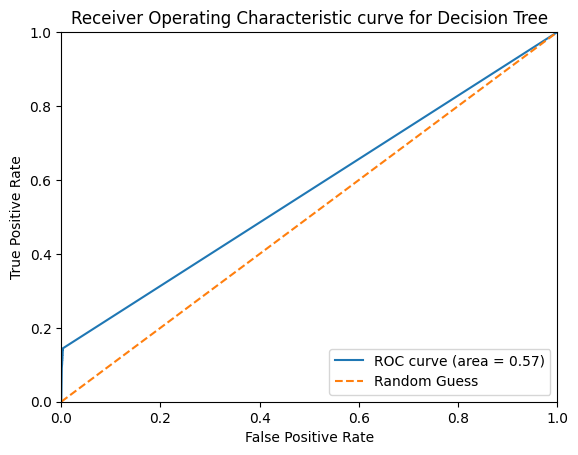

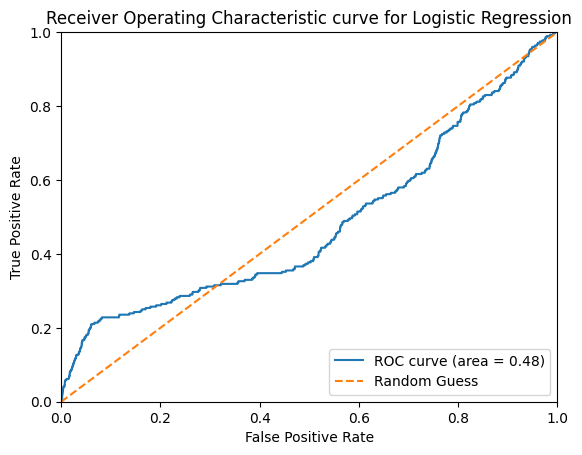

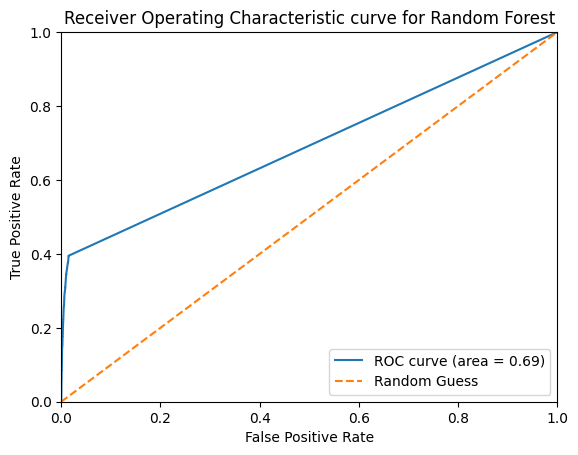

In [8]:
one_prob_dec_tree = [lst[1] for lst in y_proba_all_dec_tree]
fpr, tpr, thresholds = roc_curve(y_truth_all_dec_tree, one_prob_dec_tree)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve for Decision Tree')
plt.legend(loc="lower right")
plt.show()

one_prob_logistic = [lst[1] for lst in y_proba_all_logistic]
fpr, tpr, thresholds = roc_curve(y_truth_all_logistic, one_prob_logistic)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

one_prob_random = [lst[1] for lst in y_proba_all_random]
fpr, tpr, thresholds = roc_curve(y_truth_all_random, one_prob_random)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve for Random Forest')
plt.legend(loc="lower right")
plt.show()

#### ROC post-Smote

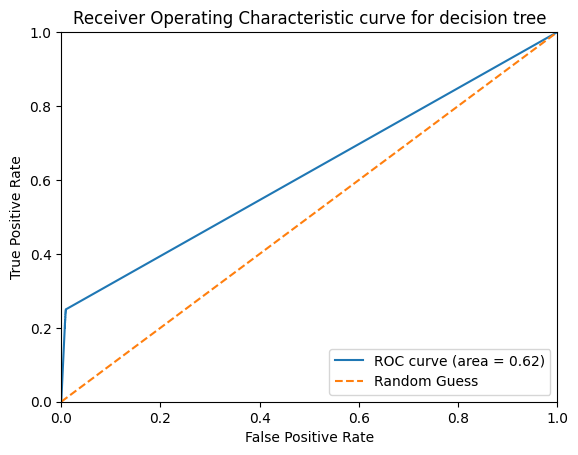

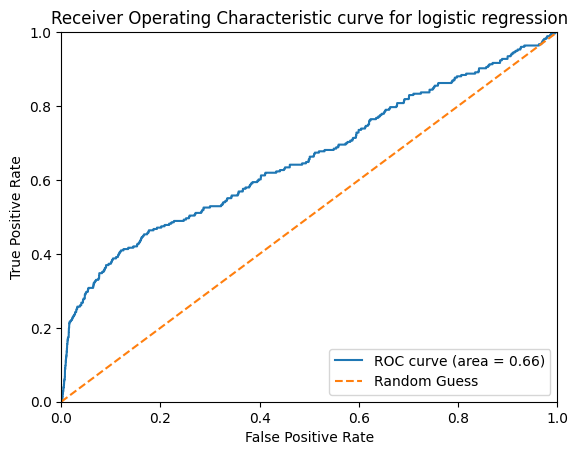

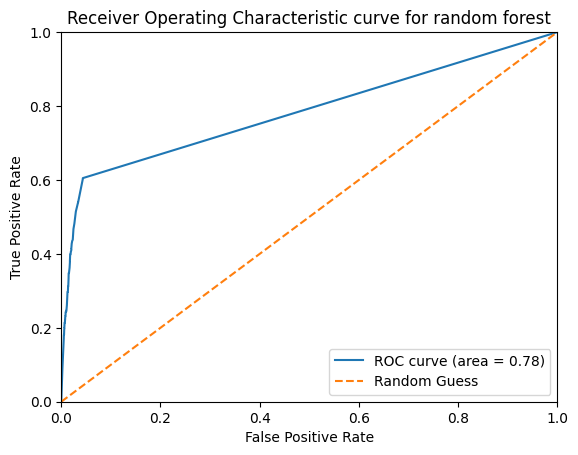

In [9]:
one_prob_dec_tree = [lst[1] for lst in y_proba_all_dec_tree_smoted]
fpr, tpr, thresholds = roc_curve(y_truth_all_dec_tree_smoted, one_prob_dec_tree)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve for decision tree')
plt.legend(loc="lower right")
plt.show()

one_prob_logistic = [lst[1] for lst in y_proba_all_logistic_smoted]
fpr, tpr, thresholds = roc_curve(y_truth_all_logistic_smoted, one_prob_logistic)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve for logistic regression')
plt.legend(loc="lower right")
plt.show()

one_prob_random = [lst[1] for lst in y_proba_all_random_smoted]
fpr, tpr, thresholds = roc_curve(y_truth_all_random_smoted, one_prob_random)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve for random forest')
plt.legend(loc="lower right")
plt.show()

### Analyse the performance of the classifiers. Explain which method performs best.

In [10]:
# print classification report for decision tree
print(classification_report(y_truth_all_dec_tree, y_predicts_all_dec_tree))

# print classification report for logistic regression
print(classification_report(y_truth_all_logistic, y_predicts_all_logistic))

# print classification report for random forest
print(classification_report(y_truth_all_random, y_predicts_all_random))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    189352
           1       0.11      0.09      0.10       276

    accuracy                           1.00    189628
   macro avg       0.56      0.54      0.55    189628
weighted avg       1.00      1.00      1.00    189628

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    189352
           1       0.00      0.00      0.00       276

    accuracy                           1.00    189628
   macro avg       0.50      0.50      0.50    189628
weighted avg       1.00      1.00      1.00    189628

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    189352
           1       0.18      0.06      0.09       276

    accuracy                           1.00    189628
   macro avg       0.59      0.53      0.55    189628
weighted avg       1.00      1.00      1.00    189628



In [11]:
# print classification report for decision tree
print(classification_report(y_truth_all_dec_tree_smoted, y_predicts_all_dec_tree_smoted))

# print classification report for logistic regression
print(classification_report(y_truth_all_logistic_smoted, y_predicts_all_logistic_smoted))

# print classification report for random forest
print(classification_report(y_truth_all_random_smoted, y_predicts_all_random_smoted))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    189352
           1       0.04      0.25      0.07       276

    accuracy                           0.99    189628
   macro avg       0.52      0.62      0.53    189628
weighted avg       1.00      0.99      0.99    189628

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    189352
           1       0.01      0.30      0.02       276

    accuracy                           0.95    189628
   macro avg       0.50      0.63      0.49    189628
weighted avg       1.00      0.95      0.97    189628

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    189352
           1       0.04      0.23      0.07       276

    accuracy                           0.99    189628
   macro avg       0.52      0.61      0.53    189628
weighted avg       1.00      0.99      0.99    189628



The ROC curve plots the true positive rate against the false positive rate, and the AUC-ROC scores indicate an improvement in model discrimination between classes post-SMOTE. Post-SMOTE, all models improved, with the ensemble nature of the Random Forest allowing it to handle the increased diversity in fraud examples effectively.

Post-SMOTE, recall for fraudulent transactions has markedly increased in all models, reflecting improved detection of positive cases. However, the precision for the minority class has dropped, indicating an increase in false positives, likely stemming from the noise introduced by synthetic minority instances via SMOTE.

- The decision tree model, which makes binary decisions based on feature values at each node, struggled with the complex decision boundaries of fraud detection tasks, possibly due to its inherent sensitivity to imbalanced datasets, leading to overfitting on the majority class.

- Upon applying SMOTE, the logistic regression, which estimating probabilities using a logistic function, model showed significant performance improvements. This improvement underlines the importance of addressing data imbalance in such predictive tasks.

- The Random Forest classifier, an ensemble of decision trees, performed strongly despite the initial dataset imbalance. This robustness was further enhanced post-SMOTE, showing notable improvement in identifying the minority class.

### Is using SMOTE a good idea? Why (not)?

Before applying SMOTE, the classifiers had difficulty identifying fraud cases due to the imbalanced dataset. Post-SMOTE, all classifiers showed improved recall, and an increased AUC, indicating better fraud detection. However, a precision drop signaled more false positives. Despite increased false positives, using SMOTE may still be preferable as it allows the detection of more potential fraud cases, thereby enhancing cardholder trust and potentially saving substantial financial losses.